In [1]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array
from PIL import Image


In [2]:
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [3]:
# Các tham số
SIZE = 128  # Kích thước ảnh đầu vào
NoofIMGs = 9001
batch_size = 16

# Đường dẫn đến các thư mục ảnh
path_1 = '/kaggle/input/face-mask-lite-dataset/without_mask'
path_2 = '/kaggle/input/face-mask-lite-dataset/with_mask'


# Hàm sắp xếp alphanumeric
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

# Đọc danh sách file và lấy đường dẫn ảnh
# for train
files_1 = sorted_alphanumeric([f for f in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, f))])[:NoofIMGs]
files_2 = sorted_alphanumeric([f for f in os.listdir(path_2) if os.path.isfile(os.path.join(path_2, f))])[:NoofIMGs]
files_3 = sorted_alphanumeric([f for f in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, f))])[NoofIMGs:]
files_4 = sorted_alphanumeric([f for f in os.listdir(path_2) if os.path.isfile(os.path.join(path_2, f))])[NoofIMGs:]
without_mask_paths = [os.path.join(path_1, fname) for fname in files_1]
with_mask_paths = [os.path.join(path_2, fname) for fname in files_2]
without_mask_val_paths=[os.path.join(path_1, fname) for fname in files_3]
with_mask_val_paths = [os.path.join(path_2, fname) for fname in files_4]

# Hàm đọc và tiền xử lý ảnh
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Đọc ảnh và chuyển sang RGB
    img = img.resize((SIZE, SIZE))  # Resize ảnh
    img = np.array(img) / 127.5 - 1.0  # Chuẩn hóa về [-1, 1]
    return tf.convert_to_tensor(img, dtype=tf.float32)

# Hàm tạo TensorFlow dataset từ các đường dẫn
def create_dataset(without_mask_paths, with_mask_paths):
    def generator():
        for without_mask_path, with_mask_path in zip(without_mask_paths, with_mask_paths):
            without_mask_img = load_and_preprocess_image(without_mask_path)
            with_mask_img = load_and_preprocess_image(with_mask_path)
            yield without_mask_img, with_mask_img

    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
        )
    )
    return dataset

# Tạo dataset và dataloader
train_dataset = create_dataset(without_mask_paths, with_mask_paths)
val_dataset=create_dataset(without_mask_val_paths, with_mask_val_paths)


# Batch và shuffle
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Kiểm tra dataset
for without_mask_img, with_mask_img in train_dataset.take(1):
    print("Without mask image shape:", without_mask_img.shape)
    print("With mask image shape:", with_mask_img.shape)
for without_mask_img, with_mask_img in val_dataset.take(1):
    print("Without mask image shape:", without_mask_img.shape)
    print("With mask image shape:", with_mask_img.shape)


Without mask image shape: (16, 128, 128, 3)
With mask image shape: (16, 128, 128, 3)
Without mask image shape: (16, 128, 128, 3)
With mask image shape: (16, 128, 128, 3)


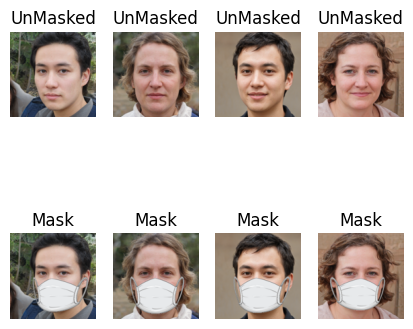

In [4]:
# Hiển thị 4 ảnh đầu tiên từ batch
for i in range(4):
    plt.subplot(2, 5, i + 1)
    plt.imshow((without_mask_img[i].numpy() + 1) / 2)  # Chuyển ảnh về [0, 1]
    plt.title("UnMasked")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow((with_mask_img[i].numpy() + 1) / 2)  # Chuyển ảnh về [0, 1]
    plt.title("Mask")
    plt.axis('off')

plt.show()


In [5]:
# Double Convolutional Block
def double_conv(in_channels, out_channels):
    return tf.keras.Sequential([
        layers.Conv2D(out_channels, kernel_size=3, padding='same', activation=None),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2D(out_channels, kernel_size=3, padding='same', activation=None),
        layers.BatchNormalization(),
        layers.ReLU()
    ])

def Generator(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv_1 = double_conv(3, 64)(inputs)
    pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = double_conv(64, 128)(pool_1)
    pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

    conv_3 = double_conv(128, 256)(pool_2)
    pool_3 = layers.MaxPooling2D(pool_size=(2, 2))(conv_3)

    conv_4 = double_conv(256, 512)(pool_3)
    pool_4 = layers.MaxPooling2D(pool_size=(2, 2))(conv_4)

    conv_5 = double_conv(512, 1024)(pool_4)

    # Decoder
    upconv_1 = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding='same')(conv_5)
    concat_1 = layers.Concatenate()([upconv_1, conv_4])
    conv_6 = double_conv(1024, 512)(concat_1)

    upconv_2 = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(conv_6)
    concat_2 = layers.Concatenate()([upconv_2, conv_3])
    conv_7 = double_conv(512, 256)(concat_2)

    upconv_3 = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(conv_7)
    concat_3 = layers.Concatenate()([upconv_3, conv_2])
    conv_8 = double_conv(256, 128)(concat_3)

    upconv_4 = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(conv_8)
    concat_4 = layers.Concatenate()([upconv_4, conv_1])
    conv_9 = double_conv(128, 64)(concat_4)

    output = layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(conv_9)

    return tf.keras.Model(inputs, output)

# Instantiate the generator
generator = tf.keras.models.load_model('/kaggle/input/asdfasdf/tensorflow2/default/1/generator_final.h5')

# Test the generator with a dummy input
dummy_input = tf.random.normal([1, 128, 128, 3])  # Batch of 1, 128x128 RGB image
output = generator(dummy_input)
print("Generator output shape:", output.shape)




Generator output shape: (1, 128, 128, 3)


In [6]:
# Lấy một batch từ train_dataset
for without_mask_imgs, with_mask_imgs in train_dataset.take(1):
    # Test generator trên ảnh không có khẩu trang
    generated_imgs = generator(with_mask_imgs)

    print(f"Input batch shape: {without_mask_imgs.shape}")
    print(f"Generated batch shape: {generated_imgs.shape}")


Input batch shape: (16, 128, 128, 3)
Generated batch shape: (16, 128, 128, 3)


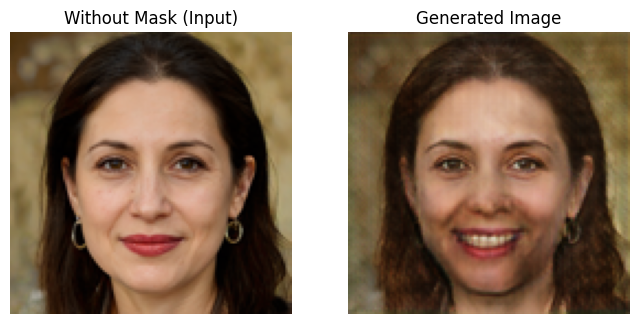

In [7]:
# Chuyển đổi từ [-1, 1] về [0, 1] để hiển thị
def denormalize(img):
    return (img + 1) / 2  # Chuyển từ [-1, 1] về [0, 1]

# Hiển thị một ảnh gốc và ảnh được tạo ra
plt.figure(figsize=(8, 4))

# Hiển thị ảnh đầu vào không có khẩu trang
plt.subplot(1, 2, 1)
plt.imshow(denormalize(without_mask_imgs[0].numpy()))  # Ảnh đầu tiên trong batch
plt.title("Without Mask (Input)")
plt.axis('off')

# Hiển thị ảnh được tạo ra bởi generator
plt.subplot(1, 2, 2)
plt.imshow(denormalize(generated_imgs[0].numpy()))  # Ảnh đầu tiên trong batch
plt.title("Generated Image")
plt.axis('off')

plt.show()


In [8]:
from tensorflow.keras import layers

def Discriminator(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", kernel_initializer="he_normal")(inputs)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)


    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)  # Output là xác suất thật/giả

    return tf.keras.Model(inputs, x)

# Instantiate the discriminator
discriminator = tf.keras.models.load_model('/kaggle/input/asdfasdf/tensorflow2/default/1/discriminator.h5')
discriminator.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        32,769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,792,897 (10.65 MB)

 Trainable params: 2,791,105 (10.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [9]:
# # Lấy một batch từ train_dataset
# for without_mask_imgs, with_mask_imgs in train_dataset.take(1):
#     # Tạo ảnh giả từ Generator
#     generated_imgs = generator(with_mask_imgs, training=False)

#     # Chạy Discriminator với ảnh thật
#     real_output = discriminator(without_mask_imgs, training=False)
#     print(f"Real output shape: {real_output.shape}")
#     print(f"Real output values: {real_output.numpy()}")

#     # Chạy Discriminator với ảnh giả
#     fake_output = discriminator(generated_imgs, training=False)
#     print(f"Fake output shape: {fake_output.shape}")
#     print(f"Fake output values: {fake_output.numpy()}")


In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)


In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [12]:
@tf.function
def train_step(without_mask_imgs, with_mask_imgs):
    # Gradient Tape cho Discriminator
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        # Generator tạo ảnh giả
        generated_imgs = generator(with_mask_imgs, training=True)

        # Discriminator phân biệt thật/giả
        real_output = discriminator(without_mask_imgs, training=True)
        fake_output = discriminator(generated_imgs, training=True)

        # Tính loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    # Tính gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Cập nhật trọng số
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [13]:
@tf.function
def val_step(without_mask_imgs, with_mask_imgs):
    # Gradient Tape cho Discriminator
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        # Generator tạo ảnh giả
        generated_imgs = generator(with_mask_imgs, training=False)

        # Discriminator phân biệt thật/giả
        real_output = discriminator(without_mask_imgs, training=False)
        fake_output = discriminator(generated_imgs, training=False)

        # Tính loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output, real_output)

    return gen_loss, disc_loss

In [14]:
# # Lấy một batch từ train_dataset
# for without_mask_imgs, with_mask_imgs in train_dataset.take(1):
#     # Chạy hàm train_step
#     gen_loss, disc_loss = train_step(without_mask_imgs, with_mask_imgs)

#     print(f"Generator Loss: {gen_loss.numpy()}")
#     print(f"Discriminator Loss: {disc_loss.numpy()}")


In [15]:
# # Debug gradient
# with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#     generated_imgs = generator(with_mask_imgs, training=True)
#     real_output = discriminator(without_mask_imgs, training=True)
#     fake_output = discriminator(generated_imgs, training=True)

#     gen_loss = generator_loss(fake_output)
#     disc_loss = discriminator_loss(fake_output, real_output)

# gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
# disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

# print("Generator Gradients:")
# for grad in gen_gradients:
#     print(grad.shape if grad is not None else None)

# print("Discriminator Gradients:")
# for grad in disc_gradients:
#     print(grad.shape if grad is not None else None)


In [16]:
# Kiểm tra thiết bị được sử dụng trong các phép tính
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0]])
    b = tf.constant([[4.0], [5.0], [6.0]])
    c = tf.matmul(a, b)
    print(c)


tf.Tensor([[32.]], shape=(1, 1), dtype=float32)


In [17]:
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6763142940167974440
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16266690560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5164727670450319572
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]



Epoch : 1
 Time:1365.01
Avg Generator Loss Train: 1.1783 Avg Discriminator Loss Train: 3.3319  Avg Generator Loss Val: 5.9922 Avg Discriminator Loss Val: 2.7152

Epoch : 2
 Time:1242.04
Avg Generator Loss Train: 1.1165 Avg Discriminator Loss Train: 2.2690  Avg Generator Loss Val: 1.3497 Avg Discriminator Loss Val: 4.0940

Epoch : 3
 Time:1086.33
Avg Generator Loss Train: 0.9180 Avg Discriminator Loss Train: 1.9949  Avg Generator Loss Val: 3.2033 Avg Discriminator Loss Val: 2.0513

Epoch : 4
 Time:1069.55
Avg Generator Loss Train: 1.1597 Avg Discriminator Loss Train: 2.0685  Avg Generator Loss Val: 5.4183 Avg Discriminator Loss Val: 2.8837

Epoch : 5


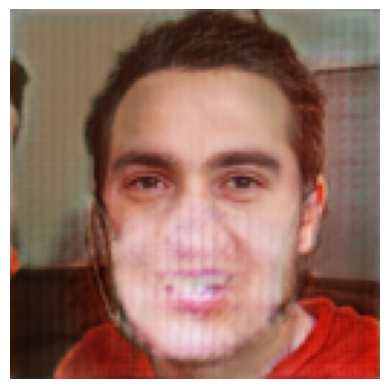

 Time:1171.47
Avg Generator Loss Train: 0.9400 Avg Discriminator Loss Train: 1.9528  Avg Generator Loss Val: 1.4185 Avg Discriminator Loss Val: 1.9987

Epoch : 6


In [ ]:
import time

# Số epoch
EPOCHS = 20
for epoch in range(EPOCHS):
    start = time.time()
    print("\nEpoch : {}".format(epoch + 1))

    # Initialize accumulators for losses
    total_gen_loss_train = 0.0
    total_dis_loss_train = 0.0
    total_gen_loss_val = 0.0
    total_dis_loss_val = 0.0
    num_batches_train= 0
    num_batches_val=0

    for without_mask_imgs, with_mask_imgs in train_dataset:
        gen_loss, disc_loss = train_step(without_mask_imgs, with_mask_imgs)
        total_gen_loss_train += gen_loss
        total_dis_loss_train += disc_loss
        num_batches_train += 1
    
    # Calculate average losses for the epoch
    avg_gen_loss_train = total_gen_loss_train / num_batches_train
    avg_dis_loss_train = total_dis_loss_train / num_batches_train


    #Validating:
    for without_mask_imgs, with_mask_imgs in val_dataset:
        gen_loss, disc_loss = val_step(without_mask_imgs, with_mask_imgs)
        total_gen_loss_val += gen_loss
        total_dis_loss_val += disc_loss
        num_batches_val += 1
    avg_gen_loss_val = total_gen_loss_val / num_batches_val
    avg_dis_loss_val = total_dis_loss_val / num_batches_val

     # Hiển thị ảnh được tạo ra mỗi vài epoch
    if (epoch + 1) % 5 == 0:
        for without_mask_imgs, _ in train_dataset.take(1):
            generated_imgs = generator(with_mask_imgs)
            plt.imshow((generated_imgs[0].numpy() + 1) / 2)  # Hiển thị ảnh đầu tiên trong batch
            plt.axis('off')
            plt.show()

    print(" Time:{}".format(np.round(time.time() - start, 2)))
    print("Avg Generator Loss Train: {:.4f} Avg Discriminator Loss Train: {:.4f}  Avg Generator Loss Val: {:.4f} Avg Discriminator Loss Val: {:.4f}".format(avg_gen_loss_train, avg_dis_loss_train,avg_gen_loss_val,avg_dis_loss_val))


In [1]:
generator.save('/kaggle/working/generator_new_final.h5')


NameError: name 'generator' is not defined